# Navigation

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.16 which is incompatible.


The environment is already saved in the Workspace and can be accessed at the file path provided below.  Please run the next code cell without making any changes.

In [2]:
from unityagents import UnityEnvironment
import numpy as np

# please do not modify the line below
env = UnityEnvironment(file_name="/data/Banana_Linux_NoVis/Banana.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [ 1.          0.          0.          0.          0.84408134  0.          0.
  1.          0.          0.0748472   0.          1.          0.          0.
  0.25755     1.          0.          0.          0.          0.74177343
  0.          1.          0.          0.          0.25854847  0.          0.
  1.          0.          0.09355672  0.          1.          0.          0.
  0.31969345  0.          0.        ]
States have length: 37


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agent while it is training**, and you should set `train_mode=True` to restart the environment.

In [7]:
env_info = env.reset(train_mode=True)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
while True:
    action = np.random.randint(action_size)        # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))

Score: 2.0


When finished, you can close the environment.

In [8]:
#env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agent while it is training.  However, **_after training the agent_**, you can download the saved model weights to watch the agent on your own machine! 

In [9]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from collections import namedtuple, deque
import random
import torch
from matplotlib import pyplot as plt
from IPython.display import display, clear_output
import time

In [25]:
class Model(nn.Module):
    """Deep Q neural network based on fully connected layers"""
    def __init__(self, state_size, action_size, hidden_size):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(state_size,hidden_size)
        self.fc2 = nn.Linear(hidden_size,hidden_size)
        self.fc3 = nn.Linear(hidden_size,action_size)
        self.action_size = action_size
    def forward(self,x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
class Agent():
    """An agent to interact with and learn from the enroment"""
    def __init__(self,state_size, action_size, hidden_size, eps_decay = 0.99, eps_min = 0.01, LR = 0.0005):
        self.q_network = Model(state_size, action_size, hidden_size).to(device)
        self.q_target_network = Model(state_size, action_size, hidden_size).to(device)
        self.q_target_network.load_state_dict(self.q_network.state_dict())
        self.q_target_network.eval()
        self.eps = 1.
        self.eps_decay = eps_decay
        self.eps_min = eps_min
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=LR)
        self.action_size = action_size
        self.loss = 0
    def act(self, state):
        """The agent act based on epsilon-greedy function"""
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.eps*=self.eps_decay
        self.eps = np.max([self.eps, self.eps_min])
        if np.random.random()>self.eps:
            self.q_network.eval()
            with torch.no_grad():
                action_values = self.q_network(state)
                action = np.argmax(action_values.cpu().data.numpy())
            self.q_network.train()
        else:
            action = np.random.choice(np.arange(self.action_size))
        return action
    def learn(self, experiences, gamma):
        """The agent learns the Q function based on Q-learning"""
        states, actions, rewards, next_states, dones = experiences
        Q = self.q_network(states).gather(1,actions)
        Q_target_next = self.q_target_network(next_states).detach().max(1)[0].unsqueeze(1)
        Q_target = rewards+gamma*(1-dones)*Q_target_next
        loss = F.mse_loss(Q,Q_target)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        self.soft_update()
        self.loss = loss.detach()
    def soft_update(self, tau = 1E-3):
        """The target Q function is updated through soft-update"""
        for params, target_params in zip(self.q_network.parameters(), self.q_target_network.parameters()):
            target_params.data.copy_(tau*params.data+(1.0-tau)*target_params.data)

class BufferReplay:
    """The expeirences of the agent is stored in BufferReplay"""
    def __init__(self, buffer_size):
        self.experience = namedtuple('Experience',['state','action','reward','next_state','done'])
        self.memory =deque(maxlen = buffer_size)
    def add(self,state,action,reward,next_state,done):
        """Experiences are added to the BufferReplay object"""
        self.memory.append(self.experience(state,action,reward,next_state,done))
    def sample(self, batch_size):
        """Experiences are sampled for learning"""
        experiences = random.sample(self.memory, k = batch_size)
        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None]).astype(np.uint8)).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
        return (states, actions, rewards, next_states, dones)
    


In [26]:
hidden_size = 64
batch_size = 64
gamma = 0.99
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
buffer_replay = BufferReplay(1000000)
agent = Agent(state_size, action_size, hidden_size)
def train(num_epochs):
    """The agent plays episodes of games and stores the experience in the BufferReplay object. 
    The stored experiences are sampled for learning."""
    score_window = deque(maxlen=100)
    scores = []
    score_100_episodes = []
    for i_episode in range(num_epochs):
        rewards = 0
        env_info = env.reset(train_mode=True)[brain_name]
        while True:
            state = env_info.vector_observations[0] 
            action = agent.act(state)        # select an action
            env_info = env.step(action)[brain_name]        # send the action to the environment
            next_state = env_info.vector_observations[0]   # get the next state
            reward = env_info.rewards[0]                   # get the reward
            rewards+=reward
            done = env_info.local_done[0]                  # see if episode has finished
            buffer_replay.add(state,action,reward,next_state,done)
            state = next_state
            if len(buffer_replay.memory) > batch_size:
                agent.learn(buffer_replay.sample(batch_size), gamma)
            if done:
                break
        score_window.append(rewards)
        scores.append(rewards)
        if i_episode >= 99:
            score_100_episodes.append(np.mean(score_window))
        if (i_episode+1)%10==0:
            print('Episode:{} __ Score:{} __ 100 episodes mean score:{}'.format(i_episode+1, rewards, np.mean(score_window)))
        if np.mean(score_window)>=13:
            print('Solved in {} episodes'.format(i_episode+1))
            torch.save(agent.q_network.state_dict(), 'checkpoint.pth')
            break
    return scores, score_100_episodes
        

In [27]:
scores, score_mean = train(1000)    

Episode:10 __ Score:2.0 __ 100 episodes mean score:0.7
Episode:20 __ Score:0.0 __ 100 episodes mean score:0.55
Episode:30 __ Score:0.0 __ 100 episodes mean score:0.4666666666666667
Episode:40 __ Score:0.0 __ 100 episodes mean score:0.6
Episode:50 __ Score:4.0 __ 100 episodes mean score:0.82
Episode:60 __ Score:6.0 __ 100 episodes mean score:1.1
Episode:70 __ Score:7.0 __ 100 episodes mean score:1.6
Episode:80 __ Score:2.0 __ 100 episodes mean score:1.8
Episode:90 __ Score:9.0 __ 100 episodes mean score:2.066666666666667
Episode:100 __ Score:10.0 __ 100 episodes mean score:2.64
Episode:110 __ Score:6.0 __ 100 episodes mean score:3.08
Episode:120 __ Score:10.0 __ 100 episodes mean score:3.83
Episode:130 __ Score:6.0 __ 100 episodes mean score:4.72
Episode:140 __ Score:8.0 __ 100 episodes mean score:5.52
Episode:150 __ Score:7.0 __ 100 episodes mean score:6.36
Episode:160 __ Score:6.0 __ 100 episodes mean score:7.04
Episode:170 __ Score:16.0 __ 100 episodes mean score:7.72
Episode:180 __ 

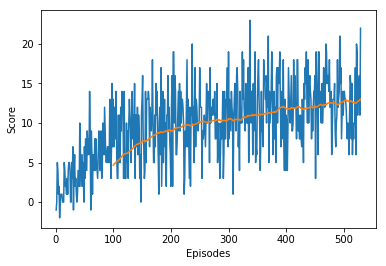

In [24]:
fig, ax = plt.subplots()
ax.plot(np.arange(1,len(scores)+1),scores, label='score')
ax.plot(np.arange(100,100+len(score_mean)),score_mean, label = 'mean score (100 episodes)')
ax.set_xlabel('Episodes')
ax.set_ylabel('Score')
fig.patch.set_facecolor('white')